两个包的链接：

Adversarial-Attacks-PyTorch:
https://github.com/Harry24k/adversarial-attacks-pytorch

PyTorch Out-of-Distribution Detection:
https://github.com/kkirchheim/pytorch-ood

CIFAR 10 Example Colab link:
https://colab.research.google.com/drive/1s9LM2jlUfrycUQ9WK4rWLxsfXb9TGFcc#scrollTo=1a-eBa-0yvAG

PGD attack paper: https://arxiv.org/pdf/1706.06083

In [ ]:
#!pip install numpy==1.23.0
#!pip install foolbox
!pip install torchattacks
!pip install adversarial-robustness-toolbox
!pip install pytorch-ood

In [2]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import datetime
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')

import torchattacks
print("torchattacks %s"%(torchattacks.__version__))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('current device:' , device)

from torch.utils.data import DataLoader
from pytorch_ood.model import WideResNet

torchattacks 3.4.0
current device: cuda:0


In [3]:
## load data and model
#from robustbench.data import load_cifar10
from robustbench.utils import load_model, clean_accuracy
import torchvision.transforms as tvt
from pytorch_ood.utils import OODMetrics, ToRGB, ToUnknown
from torchvision.datasets import CIFAR10

from torchmetrics.functional.classification import (
    binary_auroc,
    binary_precision_recall_curve,
    binary_roc,
)

# Setup preprocessing

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
trans = tvt.Compose(
    [tvt.Resize(size=(32, 32)), ToRGB(), tvt.ToTensor(), tvt.Normalize(std=std, mean=mean)]
)

dataset_in_train = CIFAR10(root="data", train=True, transform=trans, download=True)
train_loader = DataLoader(dataset_in_train, batch_size=128)

dataset_in_test = CIFAR10(root="data", train=False, transform=trans, download=True)
test_loader = DataLoader(dataset_in_test, batch_size=128)

model = WideResNet(num_classes=10, pretrained="cifar10-pt").eval().to(device)
acc = []
for images, labels in test_loader:
  acc.append( clean_accuracy(model, images.to(device), labels.to(device)) )
print('Model: {}'.format('WideResNet'))
print('-Accuracy: {}'.format(sum(acc)/len(acc)))


100%|██████████| 170498071/170498071 [00:01<00:00, 106279341.33it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Downloading: "https://github.com/wetliu/energy_ood/raw/master/CIFAR/snapshots/pretrained/cifar10_wrn_pretrained_epoch_99.pt" to /root/.cache/torch/hub/checkpoints/wrn-cifar10-pt.pt
100%|██████████| 8.62M/8.62M [00:00<00:00, 100MB/s]


Model: WideResNet
-Accuracy: 0.9490704113924051


Attack 之后的准确率为0

In [4]:
from torchattacks import PGD
print("Torchattack--PGD")

atk = PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

acc = []
for images, labels in test_loader:
  #acc.append( clean_accuracy(model, images.to(device), labels.to(device)) )
  images = atk(images, labels)
  acc.append( clean_accuracy(model, images.to(device), labels.to(device)) )
print('Model: {}'.format('WideResNet'))
print('-Accuracy: {}'.format(sum(acc)/len(acc)))

Torchattack--PGD
Model: WideResNet
-Accuracy: 9.889240506329114e-05


**Detection using Energy based method**

**分数更高表示越有可能是out of distribution**

Fitting detector
Evaluating detector


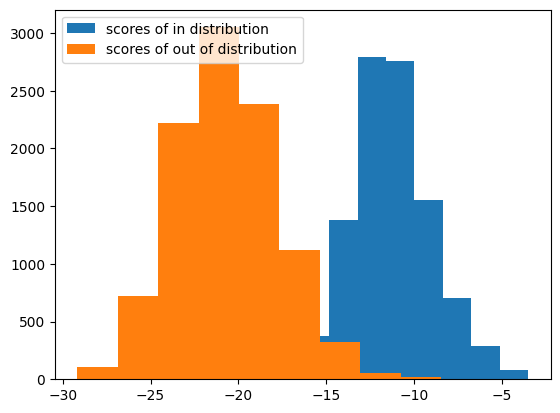

In [7]:
from pytorch_ood.detector import EnergyBased
from pytorch_ood.utils import OODMetrics

detector = EnergyBased(model)
print(f"Fitting detector")
detector.fit(train_loader, device=device)

print(f"Evaluating detector")
metrics = OODMetrics()

scores_in = []
scores_out = []

for images, labels in test_loader:
  metrics.update(detector(images.to(device)), labels.to(device))
  scores_in += list(detector(images.to(device)).cpu().detach().numpy())

  images = atk(images, labels)
  scores_out += list(detector(images.to(device)).cpu().detach().numpy())
  labels = -1 * torch.ones_like(labels)
  metrics.update(detector(images.to(device)), labels.to(device))

metrics.compute()
plt.hist(scores_in, label='scores of in distribution')
plt.hist(scores_out, label='scores of out of distribution')
plt.legend()

**使用新的attack:FGSM**

Fitting detector
Evaluating detector


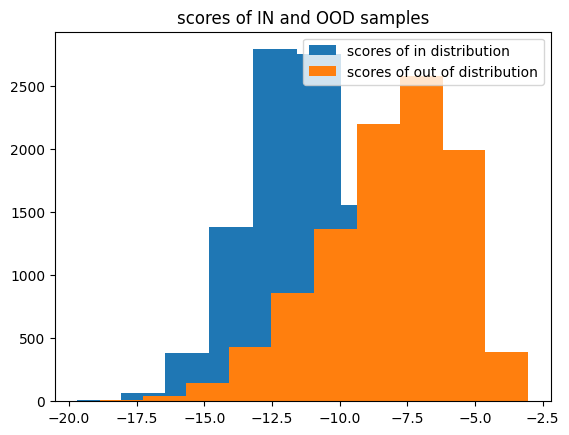

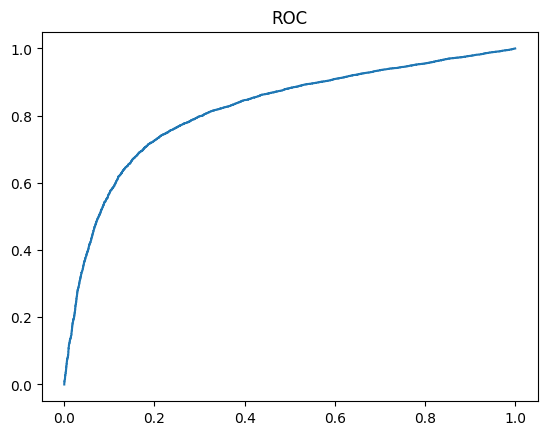

In [18]:
atk = torchattacks.FGSM(model, eps=8/255)
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
detector = EnergyBased(model)
print(f"Fitting detector")
detector.fit(train_loader, device=device)
print(f"Evaluating detector")
metrics = OODMetrics()

scores_in = []
scores_out = []

for images, labels in test_loader:
  metrics.update(detector(images.to(device)), labels.to(device))
  scores_in += list(detector(images.to(device)).cpu().detach().numpy())

  images = atk(images, labels)
  scores_out += list(detector(images.to(device)).cpu().detach().numpy())
  labels = -1 * torch.ones_like(labels)
  metrics.update(detector(images.to(device)), labels.to(device))

metrics.compute()
plt.figure(100)
plt.title('scores of IN and OOD samples')
plt.hist(scores_in, label='scores of in distribution')
plt.hist(scores_out, label='scores of out of distribution')
plt.legend()

plt.figure(101)
plt.title('ROC')
labels = metrics.buffer.get("labels").view(-1)
scores = metrics.buffer.get("scores").view(-1)
p, r, t = binary_roc(scores, labels)
plt.plot(p,r)

**New Attack:BIM**

Fitting detector
Evaluating detector


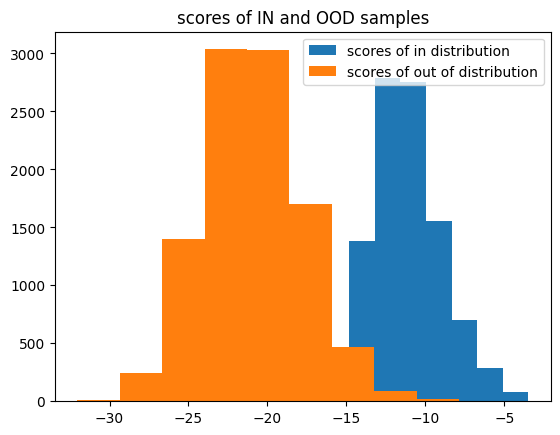

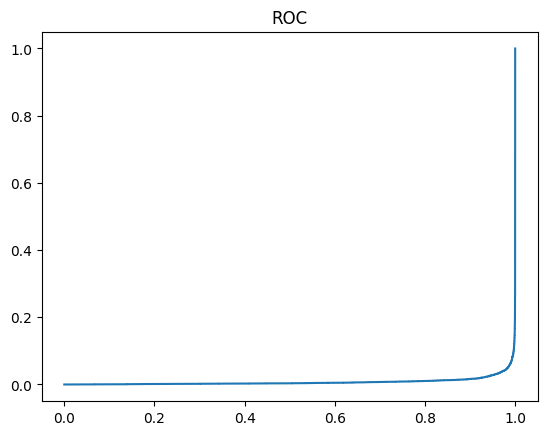

In [20]:
atk = torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=10)
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
detector = EnergyBased(model)
print(f"Fitting detector")
detector.fit(train_loader, device=device)
print(f"Evaluating detector")
metrics = OODMetrics()

scores_in = []
scores_out = []

for images, labels in test_loader:
  metrics.update(detector(images.to(device)), labels.to(device))
  scores_in += list(detector(images.to(device)).cpu().detach().numpy())

  images = atk(images, labels)
  scores_out += list(detector(images.to(device)).cpu().detach().numpy())
  labels = -1 * torch.ones_like(labels)
  metrics.update(detector(images.to(device)), labels.to(device))

metrics.compute()
plt.figure(100)
plt.title('scores of IN and OOD samples')
plt.hist(scores_in, label='scores of in distribution')
plt.hist(scores_out, label='scores of out of distribution')
plt.legend()

plt.figure(101)
plt.title('ROC')
labels = metrics.buffer.get("labels").view(-1)
scores = metrics.buffer.get("scores").view(-1)
p, r, t = binary_roc(scores, labels)
plt.plot(p,r)

Fitting detector
Evaluating detector


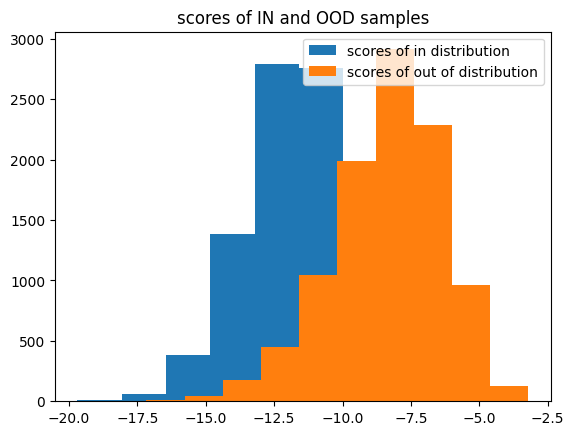

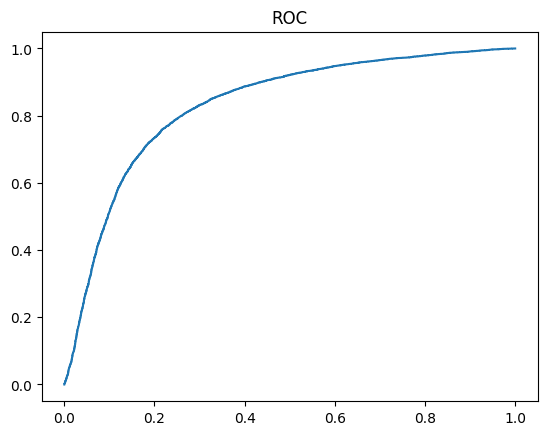

In [22]:
atk = torchattacks.CW(model, c=1, kappa=0, steps=100, lr=0.01)
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
detector = EnergyBased(model)
print(f"Fitting detector")
detector.fit(train_loader, device=device)
print(f"Evaluating detector")
metrics = OODMetrics()

scores_in = []
scores_out = []

for images, labels in test_loader:
  metrics.update(detector(images.to(device)), labels.to(device))
  scores_in += list(detector(images.to(device)).cpu().detach().numpy())

  images = atk(images, labels)
  scores_out += list(detector(images.to(device)).cpu().detach().numpy())
  labels = -1 * torch.ones_like(labels)
  metrics.update(detector(images.to(device)), labels.to(device))

metrics.compute()
plt.figure(100)
plt.title('scores of IN and OOD samples')
plt.hist(scores_in, label='scores of in distribution')
plt.hist(scores_out, label='scores of out of distribution')
plt.legend()


plt.figure(101)
plt.title('ROC')
labels = metrics.buffer.get("labels").view(-1)
scores = metrics.buffer.get("scores").view(-1)
p, r, t = binary_roc(scores, labels)
plt.plot(p,r)

threshold： This part is under modificaiton

In [ ]:
#plt.plot(t)
threshold = torch.tensor(-20)


atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
trans = tvt.Compose(
    [ToRGB(), tvt.ToTensor(), tvt.Normalize(std=std, mean=mean)]
)
dataset_in_test = CIFAR10(root="data", train=False, transform=trans, download=True)
test_loader = DataLoader(dataset_in_test, batch_size=256*2)

acc = []
for images, labels in test_loader:
  scores1 = detector(images.to(device))
  ind = scores1>=threshold
  ind = ind.to('cpu')
  images1,labels1 = images[ind],labels[ind]
  acc.append( clean_accuracy(model, images1.to(device), labels1.to(device)) )

  adv_images = atk(images, labels)
  scores2 = detector(adv_images.to(device))
  ind2 = scores2>=threshold
  ind2 = ind2.to("cpu")
  adv_images2,labels2 = adv_images[ind2],labels[ind2]
  labels2 = -1 * torch.ones_like(labels2)
  acc.append( clean_accuracy(model, adv_images2.to(device), labels2.to(device)) )

print('-Accuracy: {}'.format(sum(acc)/len(acc)))

Files already downloaded and verified
-Accuracy: 0.47424460018382353
